In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv("data/df_final.csv")
df.head()

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Niederlassung
0,64,66894.0,88160.31,1.0,43.0,K0310,Bayern
1,54,77644.0,103145.70,1.0,40.0,K1042,Berlin
2,55,44341.0,80565.16,0.0,37.0,K0382,Baden-Württemberg
3,49,67271.0,83949.89,0.0,42.0,K0498,Bayern
4,46,49832.0,93781.58,0.0,41.0,K0552,Hessen


# 1. Wie viele Autos wurden verkauft?

In [12]:
df_autos = df[df["Preis"] > 0]
df_autos["Preis"].count()

1104


# 2. Was ist der Höchst-, Mindest- und Durchschnittspreis der verkauften Autos?

In [13]:
df_autos["Preis"].min()

21471.65

In [14]:
df_autos["Preis"].max()

165482.31

In [19]:
df_autos["Preis"].mean().round(2)

88975.2

# 3. Wie hoch war der Gesamtumsatz?

In [21]:
df_autos["Preis"].sum().round(2)

98228619.38

# 4. Wie viele Autos wurden pro Bundesland verkauft?


In [17]:
niederlassung_count = df_autos['Niederlassung'].value_counts()
niederlassung_count

Niederlassung
Baden-Württemberg      205
Bayern                 188
Nordrhein-Westfalen    175
Berlin                 126
Hessen                  96
Niedersachsen           96
Sachsen                 89
Thüringen               49
Hamburg                 43
Brandenburg             37
Name: count, dtype: int64

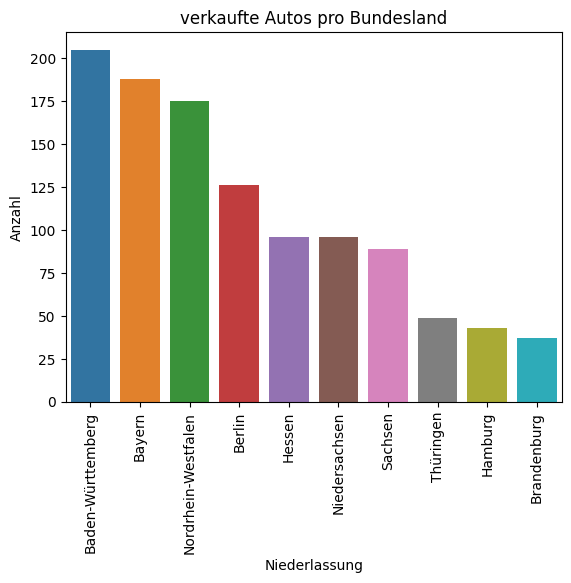

In [18]:
niederlassung_count_plot = sns.barplot(x=niederlassung_count.index,
                                       y=niederlassung_count.values,
                                       hue=niederlassung_count.index)
_ = plt.setp(niederlassung_count_plot.get_xticklabels(), rotation=90)
plt.ylabel('Anzahl')
_ = plt.title('verkaufte Autos pro Bundesland')

# 19. Auf welche Probleme sind Sie bei der Zusammenführung des Datensatzes gestoßen? Stellen Sie die Operationen vor, die Sie zum Zusammenführen und Bereinigen der Daten durchgeführt haben.

- Ausreißer
  - bei kunden_df:
    - Alter: 100 und 120 sind nicht realistische Alter für Autokäufer. Die nächste Person im Datensatz ist 70 Jahre alt. Die beiden       Einträge werden durch den Modalwert ersetzt.
      - `age_mode = cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] < 70, 'Alter'].mode()[0]`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Alter'] > 70, 'Alter'] = age_mode`
    - Einkommen: 1.000.000.000 (1 Mrd) und Einkommen 0 sind unrealistische Jahresgehälter, weshalb es durch den Median ersetzt wird (Modalwert nicht möglich, da alle Einkommensangaben einzigartig sind).
      - `income_median = cleaned_kunden_df.loc[(cleaned_kunden_df['Einkommen'] < 1000000) & (cleaned_kunden_df['Einkommen'] != 0), 'Einkommen'].median()`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] > 1000000, 'Einkommen'] = income_median`
      - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] == 0, 'Einkommen'] = income_median`
- fehlende Daten
  - kunden_df enthält 5 Reihen, wo das Geschlecht nicht ausgefüllt ist (isnull())
    - `cleaned_kunden_df = kunden_df.fillna(1.0)`
- falsche Daten
  - kunden_df enthält einen Reihe, wo das Gehalt negativ ist. Es wird davon ausgegangen, dass es sich hierbei um einen Tippfehler handelt
    - `cleaned_kunden_df.loc[cleaned_kunden_df['Einkommen'] < 0, 'Einkommen'] *= -1` 
- nicht normalisierte Daten
  - geo_df enthält Unstimmigkeiten in der Spalte Niederlassung:
    - Düsseldorf, NRW und Nordrhein-Westfalen beschreiben das gleiche Bundesland, sind aber unterschiedlich angegeben.
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'NRW', 'Niederlassung'] = 'Nordrhein-Westfalen'`
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'Düsseldorf', 'Niederlassung'] = 'Nordrhein-Westfalen'`
    - Berlin, BERLIN, Berlin-Charlottenburg und Berlin-Mitte beschreiben ebenfalls das gleiche Bundesland.
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'] == 'BERLIN', 'Niederlassung'] = 'Berlin'`
      - `cleaned_geo_df.loc[cleaned_geo_df['Niederlassung'].str.startswith('Berlin-'), 'Niederlassung'] = 'Berlin'`
- Inkonsequente Datenformate
  - Einkommen: ist in kunden_df float64, in besucher_df object
  - Geschlecht: ist in kunden_df float64, in besucher_df int64
  - Zeit: ist in kunden_df float64, in besucher_df object
  - `cleaned_besucher_df['Einkommen'] = cleaned_besucher_df['Einkommen'].str.replace(',', '.')`
  - `cleaned_besucher_df['Zeit'] = cleaned_besucher_df['Zeit'].str.replace(',', '.')`
  - `cleaned_besucher_df = cleaned_besucher_df.astype({'Geschlecht': 'float64', 'Einkommen': 'float64', 'Zeit': 'float64'})`
- Zusammenführen
  - Die Daten werden mithilfe eines Outer Joins zusammengeführt. Die NaN Werte, die dabei für die Besucher in der Spalte 'Preis' entstehen, werden im Anschluss durch 0 ersetzt.
  - `combined_df = combined_df.merge(cleaned_besucher_df, how='outer', on=['KundeNr', 'Alter', 'Einkommen', 'Geschlecht', 'Zeit'])`
  - `combined_df = combined_df.merge(cleaned_geo_df, how='outer', on='KundeNr')`
  - `combined_df = combined_df.fillna(0)`

![Visualisierung der Merge Typen in Pandas](https://miro.medium.com/v2/resize:fit:400/format:webp/1*9eH1_7VbTZPZd9jBiGIyNA.png)

Für eine ausführliche Betrachtung des Data Cleanings, siehe Datei : data_cleaning.ipynb


# 20. Welche Vorschläge würden Sie der Kundenabteilung für die Umfrage im nächsten Jahr machen? Welche zusätzlichen Informationen sollten gesammelt werden? Formulieren Sie zwei Vorschläge.

- clean data:
  - alle Daten im richtigen Format anlegen bzw. übereinstimmend über Dateien hinweg (z.B. feste Feldformatierung)
  - bei Niederlassung/Bundesländern nur vorbestimmte Antworten zulassen (z.B. über ein Dropdown Menü)
  - Regeln für Dateneingabe einführen (z.B. Einkommen muss > 0 sein)
- für Daten:
  - welches Modell wurde gekauft (Kundensegmentierung)  
  - welches Modell wurde angeschaut/getestet (Conversion Rate) 
  - wodurch auf Elektratuto AG aufmerksam geworden (Marketing)
  